## Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy import interpolate
from scipy.optimize import brentq
from scipy.optimize import least_squares
import array

%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

## Import Data

#### On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR S&P500 Exchange Traded Fund (SPY) stock price was 366.02.


- The fundamental difference is that \^SPX options are based on the $\$$S&P 500 Index, while SPY options are based on the $\$$Spdr S&P 500 ETF that tracks the index.
- Each SPX contract is about 10 times the value of a SPY option because the S&P 500 Index is approximately 10X times higher than SPY in numerical terms. The price of a share of SPY is intended to be one-tenth that of the S&P 500 Index. So, if the S&P is at a level of 4,000, then one SPY share should trade at close to $400.

In [2]:
spx = pd.read_csv('SPX_options.csv') #European
spy = pd.read_csv('SPY_options.csv') #American
rates = pd.read_csv('zero_rates_20201201.csv') #discount rate on 1st dec 2020

In [ ]:
# spx.exercise_style.unique()
# spy.exercise_style.unique()# 

## Clean Data

In [3]:
spx['strike_price'] = spx['strike_price']/ 1000
spy['strike_price'] = spy['strike_price']/100

# Calculating Mid Price (using it to calculate market implied volatility)
# spx['midprice'] = (spx['best_bid'] + spx['best_offer']) / 2
# spy['midprice'] = (spy['best_bid'] + spy['best_offer']) / 0.2
spx['midprice'] = (spx['best_bid'] + spx['best_offer']) / 2
spy['midprice'] = (spy['best_bid'] + spy['best_offer']) / 2

# Changing columns to datetime format
spx['exdate'] = pd.to_datetime(spx['exdate'],format='%Y%m%d')
spx['date'] = pd.to_datetime(spx['date'],format='%Y%m%d')
spx['maturityDays'] = (spx['exdate'] - spx['date']).dt.days
maturitiesDays_spx =  spx['maturityDays'].unique()

spy['exdate'] = pd.to_datetime(spy['exdate'],format='%Y%m%d')
spy['date'] = pd.to_datetime(spy['date'],format='%Y%m%d')
spy['maturityDays'] = (spy['exdate'] - spy['date']).dt.days
maturitiesDays_spy =  spy['maturityDays'].unique()

# Inteprolating rates
iRates = []
f=interpolate.interp1d(rates['days'].values,rates['rate'].values)

# Doing this once since maturitiesDays_spx == maturitiesDays_spy
for day in maturitiesDays_spx:
    tempRate=f(int(day))
    r = tempRate / 100
    iRates.append(r)

# (1) Calibrate Displaced-Diffusion Model (DDM) 
- ###  Report $\alpha$ and $\beta$

In [4]:
class DisplacedDiffusionModel:
    def __init__(self, F, K, r, sigma, T, beta):
        self.F = F
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.beta = beta

    def price(self, cp_flag):
        # Calculate the displaced diffusion parameters
        ddm_F = self.F / self.beta
        ddm_sigma = self.sigma * self.beta
        ddm_K = self.K + (1 - self.beta) * ddm_F * np.exp(self.r * self.T)

        # Calculate the black model price
        if (cp_flag.upper() == 'C'):
            black_price = BlackCall(ddm_F, ddm_K, self.r, ddm_sigma, self.T)
        
        elif (cp_flag.upper() == 'P'):
            black_price = BlackPut(ddm_F, ddm_K, self.r, ddm_sigma, self.T)
        
        else:
            raise NameError('Option type not recognized')

        # Return the displaced diffusion price
        return black_price

def BlackCall(F, K, r, sigma, T):
    d1 = (np.log(F / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return np.exp(-r*T) * (F*norm.cdf(d1) - K*norm.cdf(d2))

def BlackPut(F, K, r, sigma, T):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    return np.exp(-r*T) * (K*norm.cdf(-d2) - F*norm.cdf(-d1))

In [ ]:
## DDM TEST

# S, K, r, sigma, T = np.linspace(0, 100, 100), 50, iRates[0], 0.03, 1

# F = S * np.exp(r * T)

# plt.axvline(K, color='r', linestyle='--', label="Strike @ 50");
# plt.plot(S, DisplacedDiffusionModel(F, K, r, sigma, T, beta=0.7).price(cp_flag='P'), 'b');
# plt.xlabel("Forward Price ($)");
# plt.ylabel("Payoff ($)");
# plt.grid(True, ls='dotted');
# plt.title("Beta = 0.7");

In [5]:
def impliedVolatility(F, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackCall(F, K, r, x, T),
                                1e-12, 10.0)
#             print(impliedVol)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackPut(F, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
            
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [6]:
# Function which computes the vector of residuals
def ddcalibration(x, strikes, prices, F, T, r, payoff):
    err = 0.0
    for i, price in enumerate(prices):
        if (payoff[i].lower() == 'c'):
            err += (price - DisplacedDiffusionModel(F, strikes[i], r, x[0], T, x[1]).price('c'))**2
        elif (payoff[i].lower() == 'p'):
            err += (price - DisplacedDiffusionModel(F, strikes[i], r, x[0], T, x[1]).price('p'))**2
        else:
            raise NameError('Payoff type not recognized')
            
    return np.sqrt(err)

In [7]:
# Calibrating for SPX options (Calculating Market Implied Volatility across the 3 maturities)
def spx_with_impVol():
    # On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45
    tmp_spx = spx.copy()
    
    SPX_price = 3662.45
    SPXresult = pd.DataFrame()
#     SPXresult = []

    for day in maturitiesDays_spx:
        
        tempIndex = np.where(maturitiesDays_spx == day)[0][0]
        r = iRates[tempIndex]
        T = day /365
        F = SPX_price * np.exp(r*T)
        
        tempDf = tmp_spx[(tmp_spx['maturityDays'] == day)]
        tempDf['r']  = r
        tempDf['T']  = T
        tempDf['F']  = F
        tempDf['S']  = SPX_price
        
        #Filtering options prices (if K < F: use put, if K > F: use call) - we only want ATM and OTM
        tempDfCall = tempDf.drop(tempDf.index[(tempDf['strike_price'] < F) | (tempDf['cp_flag'] == 'P')])
        tempDfPut = tempDf.drop(tempDf.index[(tempDf['strike_price'] > F) | (tempDf['cp_flag'] == 'C')]) 
        
        # Calculating mkt implied vol for SPX Call
        otmc_p = tempDfCall['midprice']
        otmc_k = tempDfCall['strike_price']
        
        tempCallVol = []
        for i in range(len(otmc_p)):
            impliedvol = impliedVolatility(F, otmc_k.iloc[i], r, otmc_p.iloc[i], T, 'call')
#             print(impliedvol)
            tempCallVol.append(impliedvol)

        tempDfCall['impliedVol'] = tempCallVol

        # Calculating mkt implied vol for SPX Put
        otmp_p = tempDfPut['midprice']
        otmp_k = tempDfPut['strike_price']
        
        tempPutVol = []
        for i in range(len(otmp_p)):
            impliedvol = impliedVolatility(F, otmp_k.iloc[i], r, otmp_p.iloc[i], T, 'put')
            tempPutVol.append(impliedvol)

        tempDfPut['impliedVol'] = tempPutVol

        #Consolidating data across maturities
#         SPXresult.append(tempDfCall)
#         SPXresult.append(tempDfPut)
        SPXresult = pd.concat([SPXresult, tempDfCall], axis=0, ignore_index=True)
        SPXresult = pd.concat([SPXresult, tempDfPut], axis=0, ignore_index=True)
        

    return SPXresult

# (2) Calibrate SABR Model 
- ###  Report $\alpha$, $\rho$ and $\nu$

In [101]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [107]:
def sabrcalibration(x, beta, strikes, vols, F, T):
    err = 0.0
    
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T, x[0], beta, x[1], x[2]))**2

    return np.sqrt(err)

# (3) Plot Implied Volatility  

In [121]:
def plotImpliedVol(spx_df, maturity):
    df = spx_df.copy()
    
    F = df['F'].values[0]
    T = df['T'].values[0]
    r = df['r'].values[0]
    
    # DDM
    initialGuessDD = [0.1, 0.3]
    DDres = least_squares(lambda x: ddcalibration(x,
                                                  df['strike_price'].values,
                                                  df['midprice'].values,
                                                  F,
                                                  T,
                                                  r,
                                                  df['cp_flag'].values),
                                                  initialGuessDD,
                                                  bounds = ([-np.inf, 0],[np.inf, 1]))
                            
    ddsigma = DDres.x[0]
    ddbeta = DDres.x[1]
    
    print('Calibrated Displaced Diffusion model parameters: sigma = {0:.3f}, beta = {1:.3f}'.format(ddsigma, ddbeta))
    
    ddvols = []
    for i, strike in enumerate(df['strike_price'].values):
        if (df['cp_flag'].iloc[i].upper() == 'C' and (df['strike_price'].iloc[i] > F)):
            tempPrice = DisplacedDiffusionModel(F, strike, r, ddsigma, T, ddbeta).price('c')
            implied_vol = impliedVolatility(F, strike, r, tempPrice, T, 'call')
            ddvols.append(implied_vol)
            
        elif (df['cp_flag'].iloc[i].upper() == 'P' and (df['strike_price'].iloc[i] < F)):
            tempPrice = DisplacedDiffusionModel(F, strike, r, ddsigma, T, ddbeta).price('p')
            implied_vol = impliedVolatility(F, strike, r, tempPrice, T, 'put')
            ddvols.append(implied_vol)
            
        else:
            print("This strike {0} at index {1} got problem.".format(strike, i))
            implied_vol = np.nan
        
#         print("the count is {0} at strike {1} and the implied vol is {2}".format(i, strike, implied_vol))
#         ddvols.append(implied_vol)

#     print("The length of ddvols list is {}".format(len(ddvols)))
    
    df["ddvols"] = ddvols
    
    #------------------------------------------------------------*/
    # SABR MODEL
    initialGuessSABR = [0.02, 0.2, 0.1]
    # Fixed β = 0.7
    beta = 0.7
    SABRres = least_squares(lambda x: sabrcalibration(x, beta,
                                                  df['strike_price'].values,
                                                  df['impliedVol'].values,
                                                  F,
                                                  T),
                                                  initialGuessSABR)
    alpha = SABRres.x[0]
    rho = SABRres.x[1]
    nu = SABRres.x[2]


    print('Calibrated SABR model parameters: alpha = {0:.3f}, beta = {1:.1f}, rho = {2:.3f}, nu = {3:.3f}'.format(alpha, beta, rho, nu))
    
    sabrvols = []
    for strike in df['strike_price']:
        sabrvols.append(SABR(F, strike, T, alpha, beta, rho, nu))
        
    df["sabrvols"] = sabrvols
    
    df.sort_values(by=['strike_price'], ascending=True, inplace=True)
    
    plt.figure(tight_layout=True, figsize = (20,8))
    plt.plot(df['strike_price'], df['impliedVol'], 'gs', markersize=3, label='Market Volatility')
    plt.plot(df['strike_price'], df["sabrvols"], 'b--', lw=0.8, label='SABR Volatility')
    plt.plot(df['strike_price'], df["ddvols"], 'r--', lw=0.8, label='Displaced Diffusion Volatility')
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title("Graph of Implied Volatility against Strike Price for Maturity = {} days".format(maturity))
    plt.legend()
    plt.grid(True, ls='dotted')
    plt.show()

In [115]:
SPXresult = spx_with_impVol()

Calibrated Displaced Diffusion model parameters: sigma = 0.183, beta = 0.287
Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


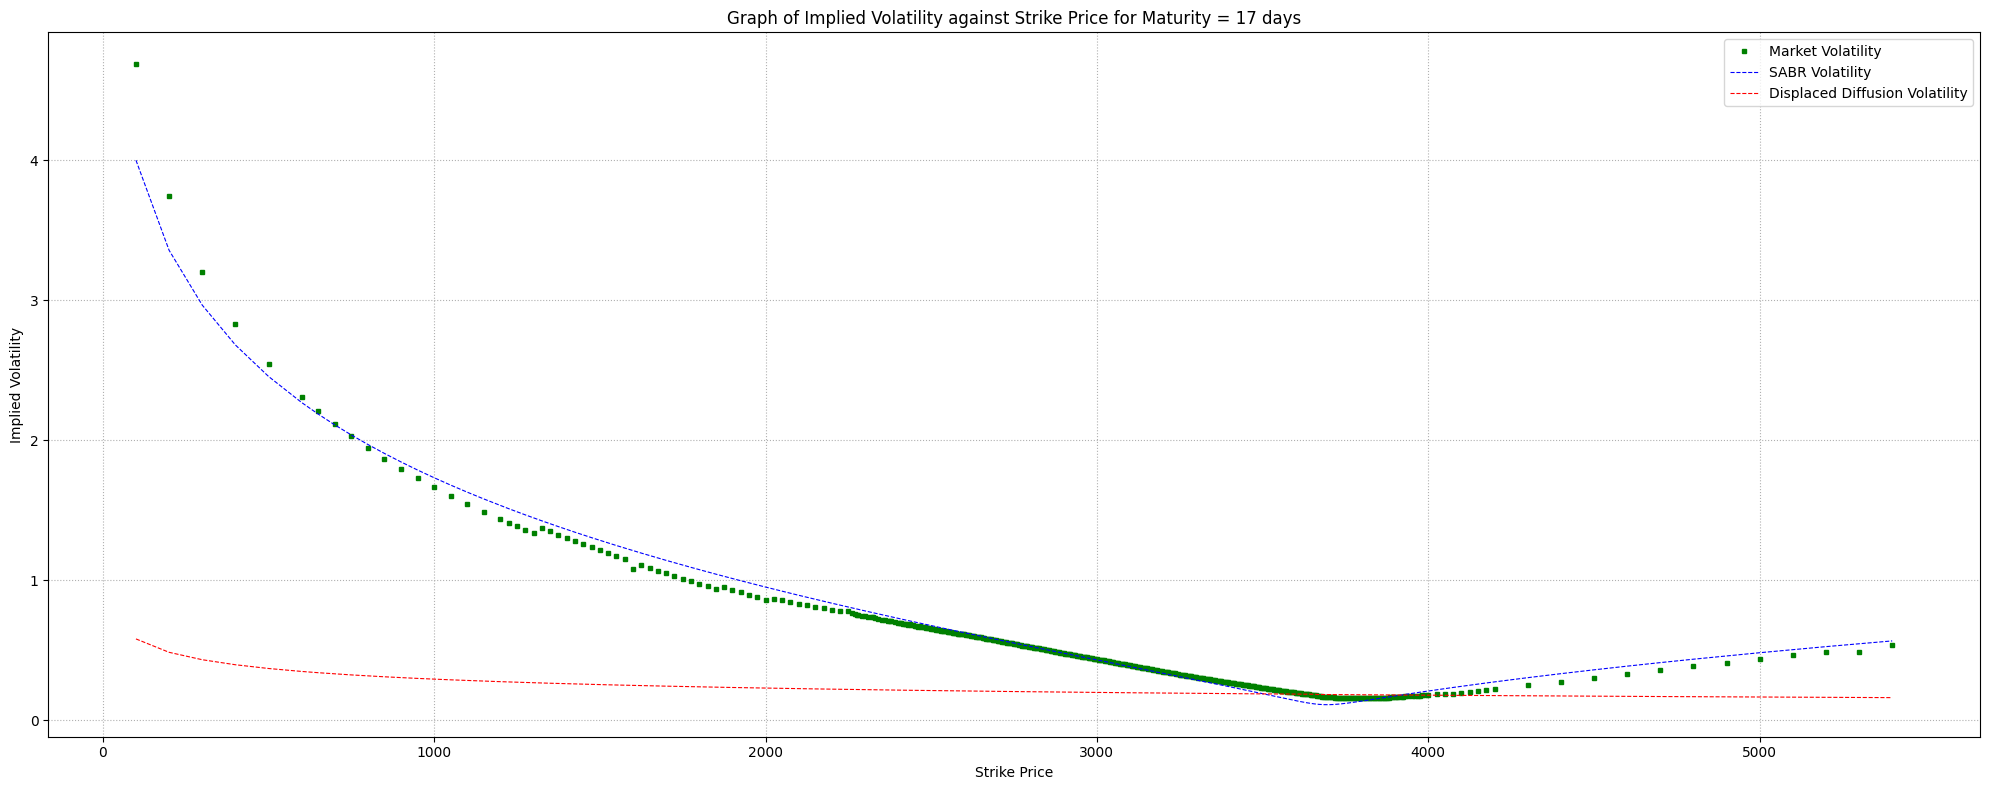

In [122]:
tempResult1 = SPXresult[SPXresult['maturityDays'] == 17]
plotImpliedVol(tempResult1, 17)

Calibrated Displaced Diffusion model parameters: sigma = 0.195, beta = 0.265
Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


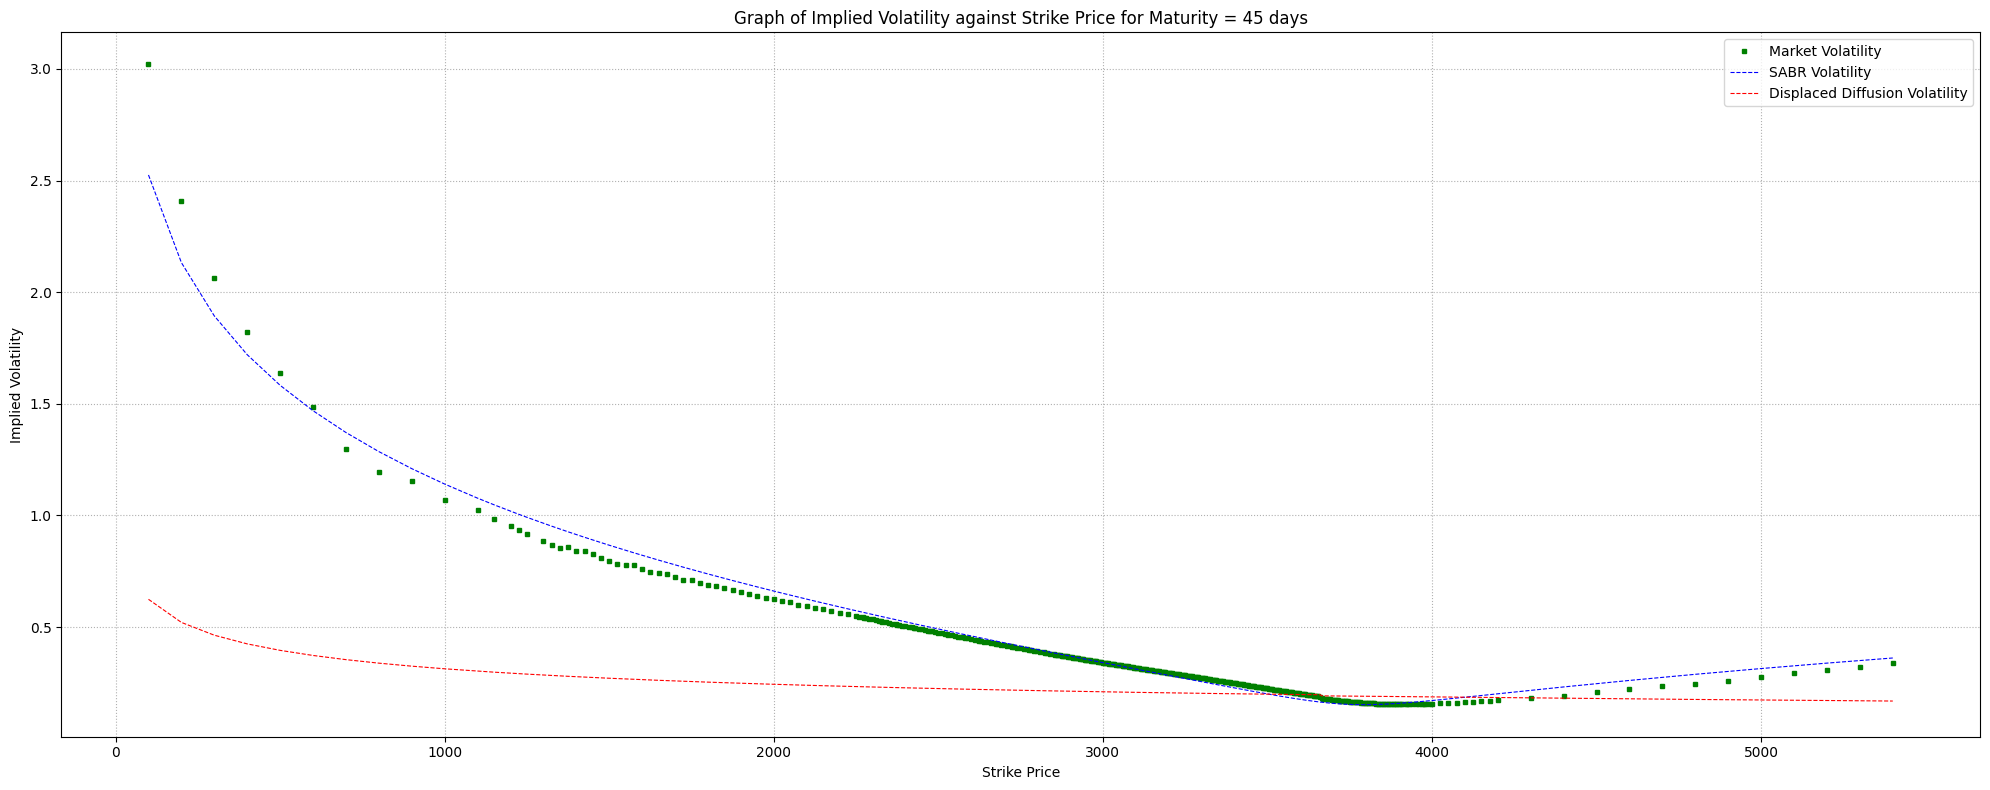

In [123]:
tempResult2 = SPXresult[SPXresult['maturityDays'] == 45]
plotImpliedVol(tempResult2, 45)

Calibrated Displaced Diffusion model parameters: sigma = 0.202, beta = 0.250
Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


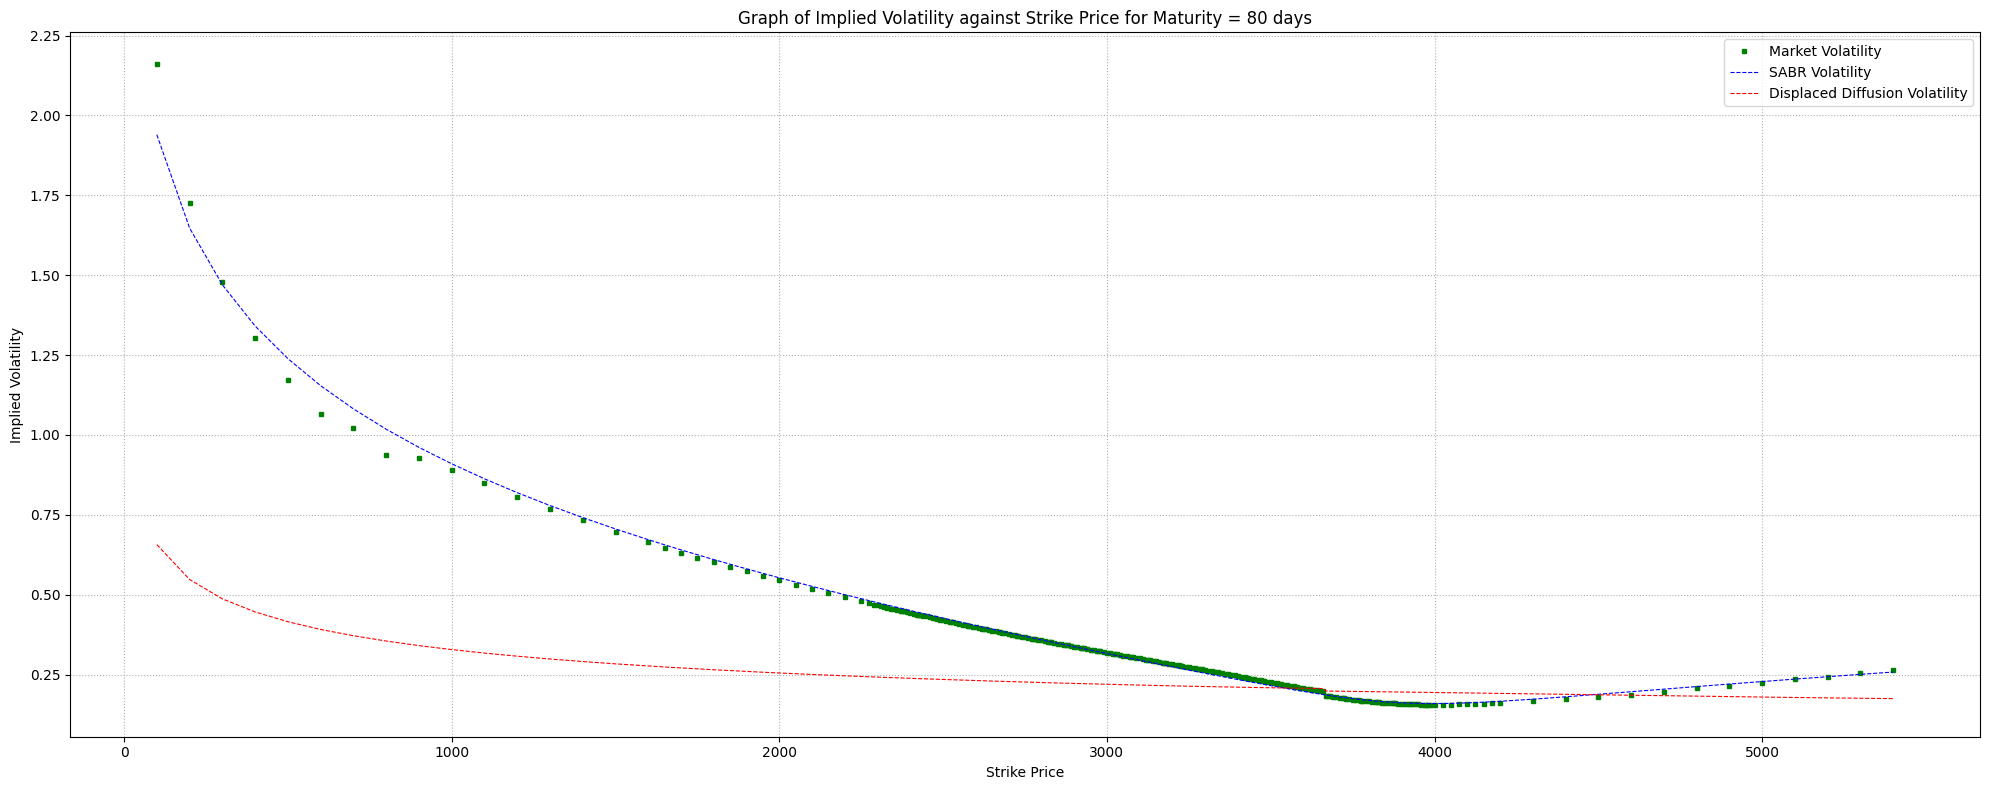

In [124]:
tempResult3 = SPXresult[SPXresult['maturityDays'] == 80]
plotImpliedVol(tempResult3, 80)